In [11]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC



In [12]:
# features.drop(['center_time', 'start_time', 'end_time', 'gyr_x_permutation_entropy', 'gyr_y_permutation_entropy', 'gyr_z_permutation_entropy', 'gyr_mag_permutation_entropy', 'gyr_x_spectral_entropy', 'gyr_y_spectral_entropy', 'gyr_z_spectral_entropy', 'gyr_mag_spectral_entropy'], axis=1, inplace=True)
features = pd.read_csv('/home/edumaba/Public/MPhil_Thesis/Code/uropatch-data-analysis/feature_based_data/three_class_up_2s.csv')

features.drop(['center_time', 'start_time', 'end_time'], axis= 1, inplace=True)
features


,acc_x_permutation_entropy,acc_x_spectral_entropy,acc_x_mean,acc_x_std,acc_x_range,acc_x_rms,acc_x_var,acc_x_min,acc_x_max,acc_x_time_energy,...,acc_mag_std,acc_mag_range,acc_mag_rms,acc_mag_var,acc_mag_min,acc_mag_max,acc_mag_time_energy,acc_mag_spectral_energy,label,experiment_id
0,0.838257,0.640434,1.027166,1.006075,5.419620,1.437796,1.012187,-1.184994,4.234626,289.415987,...,0.910694,4.247046,1.881658,0.829364,0.168266,4.415312,495.688987,69396.458205,pre-void,1
1,0.837870,0.624751,1.050145,0.936625,5.419620,1.407149,0.877266,-1.184994,4.234626,277.209703,...,0.881961,4.247046,1.783063,0.777855,0.168266,4.415312,445.103663,62314.512886,pre-void,1
2,0.830795,0.635881,0.996281,0.888150,5.419620,1.334686,0.788810,-1.184994,4.234626,249.394121,...,0.847308,4.247046,1.714364,0.717932,0.168266,4.415312,411.466194,57605.267222,pre-void,1
3,0.836304,0.629307,0.931380,0.584322,3.559709,1.099500,0.341432,-0.261238,3.298471,169.246134,...,0.587919,3.197414,1.424697,0.345648,0.407560,3.604973,284.166609,39783.325254,pre-void,1
4,0.859942,0.753119,0.764054,0.266251,1.494012,0.809116,0.070890,-0.129043,1.364970,91.653628,...,0.268105,1.299565,1.116902,0.071880,0.582435,1.882000,174.645666,24450.393183,pre-void,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6077,0.920146,0.831353,-0.295279,0.125458,0.633012,0.320826,0.015740,-0.631435,0.001576,14.410112,...,0.163984,0.710540,0.702583,0.026891,0.367051,1.077591,69.107282,9675.019479,post-void,41
6078,0.929034,0.863475,-0.254916,0.087360,0.489096,0.269470,0.007632,-0.487519,0.001576,10.165948,...,0.128093,0.659666,0.658737,0.016408,0.367051,1.026717,60.750744,8505.104187,post-void,41
6079,0.935790,0.863697,-0.255064,0.096241,0.492340,0.272617,0.009262,-0.490763,0.001576,10.404812,...,0.126025,0.585194,0.646850,0.015882,0.361666,0.946861,58.578039,8200.925467,post-void,41
6080,0.939007,0.821863,-0.278075,0.094329,0.492340,0.293638,0.008898,-0.490763,0.001576,12.071292,...,0.118433,0.610268,0.684313,0.014026,0.361666,0.971934,65.559804,9178.372591,post-void,41


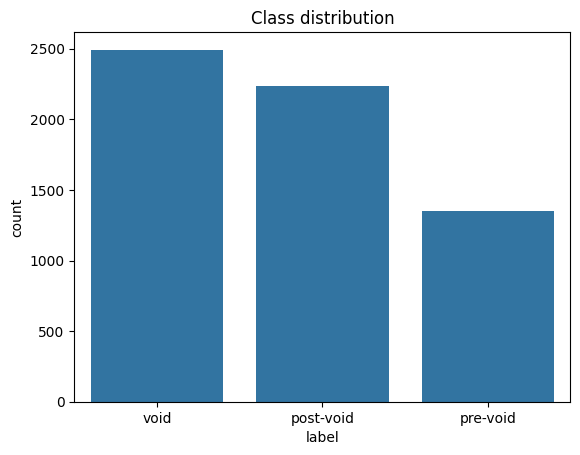

In [13]:
plt.figure()
sns.countplot(x = 'label',
            data = features,
            order = features.label.value_counts().index)
plt.title('Class distribution')
plt.show()

In [14]:
X = features.drop(columns=['label', 'experiment_id'])
y = features['label']
groups = features['experiment_id']

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [15]:
# Feature scaling (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Encode string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [21]:
# Load pretrained model
with open('/home/edumaba/Public/MPhil_Thesis/Code/uropatch-data-analysis/svm_pretrained_model/trained_svm_model.pkl', 'rb') as f:
    clf = pickle.load(f)

/home/edumaba/Public/MPhil_Thesis/Code/uropatch-data-analysis/.venv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/edumaba/Public/MPhil_Thesis/Code/uropatch-data-analysis/.venv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator OneVsRestClassifier from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/edumaba/Public/MPhil_Thesis/Code/uropatch-data-analysis/.venv/lib/python3.12/site-packages/sklearn/b

In [18]:
# Classification report
y_pred = label_encoder.inverse_transform(clf.predict(X_test_scaled))
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

   post-void       0.61      0.44      0.51       694
    pre-void       0.29      0.27      0.28       295
        void       0.60      0.79      0.68       636

    accuracy                           0.55      1625
   macro avg       0.50      0.50      0.49      1625
weighted avg       0.55      0.55      0.54      1625



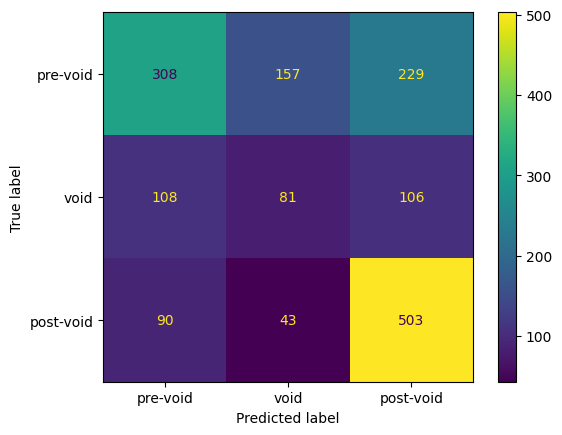

In [19]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['pre-void', 'void', 'post-void'])
cm_display.plot()
plt.show()